In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
from omegaconf import OmegaConf
from models.flow_module import FlowModule
import torch
from data.pdb_dataloader import PdbDataModule
import GPUtil
from data import utils as du
import numpy as np
import tree
from data import so3_utils
from data import all_atom
from analysis import utils as au
from openfold.utils.superimposition import superimpose
import matplotlib.pyplot as plt


In [3]:
save_dir = 'notebook_samples/'
num_timesteps = 100
os.makedirs(save_dir, exist_ok=True)


In [24]:
# Setup lightning module

ckpt_dir = '../ckpt/se3-fm/only_noise_rots/2023-09-22_18-07-14'
# ckpt_dir = '../ckpt/se3-fm/baseline_faster/2023-09-23_08-04-04'
# ckpt_dir = '../ckpt/se3-fm/baseline_faster/2023-09-21_23-35-40'
# ckpt_dir = '../ckpt/se3-fm/t_clip_trans_weight_2/2023-09-21_19-53-00'
ckpt_path = os.path.join(ckpt_dir, 'epoch=9-step=9850.ckpt')

print(ckpt_path)

base_path = '../configs/base.yaml'
base_cfg = OmegaConf.load(base_path)

cfg_path = os.path.join(ckpt_dir, 'config.yaml')
ckpt_cfg = OmegaConf.load(cfg_path)

OmegaConf.set_struct(base_cfg, False)
OmegaConf.set_struct(ckpt_cfg, False)
cfg = OmegaConf.merge(base_cfg, ckpt_cfg)
cfg.experiment.checkpointer.dirpath = './'
cfg.experiment.rescale_time = False
cfg.data.dataset.csv_path = '../preprocessed/metadata.csv'

flow = FlowModule.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    model_cfg=cfg.model,
    experiment_cfg=cfg.experiment
)
_ = flow.eval()


../ckpt/se3-fm/only_noise_rots/2023-09-22_18-07-14/epoch=9-step=9850.ckpt


In [25]:
# Set up data module
data_module = PdbDataModule(cfg.data)
data_module.setup('fit')
train_dataloader = data_module.train_dataloader(
    num_replicas=1,
    rank=1
)
data_iter = iter(train_dataloader)


In [26]:
# Search for a reasonable batch
stop_search = False
while not stop_search: 
    batch = next(data_iter)
    num_batch, num_res, _ = batch['trans_1'].shape
    if num_res > 80:
        stop_search = True

print(f'Found batch with {num_res} residues, {num_batch} batch size')

# Set up device and cuda
num_batch, num_res, _ = batch['trans_1'].shape
cuda_id = GPUtil.getAvailable(order='memory', limit = 8)[0]
device = f'cuda:{cuda_id}'
# device = 'cpu'
print(f'Using device {device}')
flow.model = flow.model.to(device)
batch = tree.map_structure(lambda x: x.to(device), batch)
num_batch = batch['res_mask'].shape[0]

Found batch with 108 residues, 62 batch size
Using device cuda:4


# Model prediction at different timesteps

In [27]:
gt_ca_pos = batch['trans_1']
device = gt_ca_pos.device
num_batch = gt_ca_pos.shape[0]
ts = np.linspace(1e-3, 1.0, num_timesteps)
all_pred_ca = []
all_pred_transrot = []
all_pred_rots_vf = []
all_gt_atom37 = []
all_gt_rots_vf = []

for i,t in enumerate(ts):
    if i % 100 == 0:
        print(f'On t={t:.2f}')
    batch_t = torch.ones(num_batch, 1, 1, device=device) * t
    noisy_batch = flow._corrupt_batch(batch, t=batch_t)
    noisy_batch['t']
    with torch.no_grad():
        model_out = flow.forward(noisy_batch)
    all_pred_rots_vf.append(du.to_numpy(model_out['pred_rots_vf']))
    all_pred_transrot.append((model_out['pred_trans'], model_out['pred_rots'].get_rot_mats()))
    all_pred_ca.append(du.to_numpy(model_out['pred_trans']))

    gt_trans_t = noisy_batch['trans_t']
    gt_rotmats_t = noisy_batch['rotmats_t']

    gt_rot_vf = so3_utils.calc_rot_vf(
        noisy_batch['rotmats_t'].type(torch.float32),
        noisy_batch['rotmats_1'].type(torch.float32)
    )
    all_gt_rots_vf.append(du.to_numpy(gt_rot_vf))

    noisy_gt_atom37 = all_atom.atom37_from_trans_rot(
        gt_trans_t.detach().cpu(),
        gt_rotmats_t.detach().cpu(),
        noisy_batch['res_mask'].detach().cpu()
    )
    noisy_gt_atom37 = du.to_numpy(noisy_gt_atom37)
    all_gt_atom37.append(noisy_gt_atom37)

all_gt_rots_vf = np.stack(all_gt_rots_vf)
all_pred_rots_vf = np.stack(all_pred_rots_vf)

On t=0.00


/data/rsg/chemistry/jyim/mambaforge/envs/fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


In [8]:
# # Save samples
# all_pred_ca = np.stack(all_pred_ca)
# all_pred_atom37 = np.stack(all_atom.transrot_to_atom37(
#     all_pred_transrot,
#     noisy_batch['res_mask']
# ))

# os.makedirs(save_dir, exist_ok=True)
# num_timesteps, num_batch, num_res, _, _ = all_pred_atom37.shape

# for i in list(np.linspace(0, num_timesteps-1, 10).astype(int)):
#     t = ts[i]
#     atom37_t = all_pred_atom37[i]
#     _ = au.write_prot_to_pdb(
#         atom37_t,
#         os.path.join(
#             save_dir,
#             f'model_out_len_{num_res}_t_{t:.2f}.pdb'),
#         no_indexing=True
#     )
#     _ = au.write_prot_to_pdb(
#         all_gt_atom37[i],
#         os.path.join(
#             save_dir,
#             f'gt_len_{num_res}_t_{t:.2f}.pdb'),
#         no_indexing=True)
    
#     print(f'Done with sample {i}, t={t:.2f}')

In [28]:

rots_vf_rmsd = np.linalg.norm(
    (all_gt_rots_vf - all_pred_rots_vf), axis=-1).reshape(num_timesteps, -1)
rots_rmsd = np.mean(rots_vf_rmsd, axis=-1)
res_mask = batch['res_mask']
# _, aligned_rmsd = superimpose(
#     torch.tensor(gt_ca_pos)[None].repeat(num_timesteps, 1, 1, 1) * 0.1 * torch.tensor(t_weight, device=device)[:, None, None, None],
#     torch.tensor(all_pred_ca).to(gt_ca_pos.device) * 0.1 * torch.tensor(t_weight, device=device)[:, None, None, None],
#     res_mask[None].repeat(num_timesteps, 1, 1)
# )
# aligned_trans_rmsd = du.to_numpy(torch.mean(aligned_rmsd, dim=-1))
# unaligned_trans_rmsd = np.mean(np.linalg.norm((np.stack(all_pred_ca) - du.to_numpy(gt_ca_pos)[None]) * 0.1, axis=-1), axis=(-1, -2))


In [ ]:
# new_ts = torch.minimum(torch.linspace(1e-3, 1.0, num_timesteps), torch.tensor(0.8))
# plt.plot(ts, du.to_numpy(1 / (1 - new_ts)**2))
# plt.xlabel(r'$t$')
# plt.ylabel(r'$\frac{1}{(1-t)^2}$')
# plt.title('Clipped loss t weighting')

Text(0.5, 1.0, 'Model prediction error across time t')

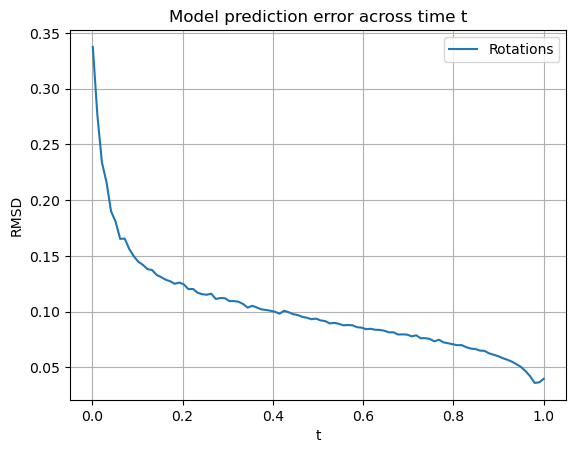

In [31]:
plt.plot(ts, rots_rmsd, label='Rotations')
# plt.plot(ts, aligned_trans_rmsd, label='Aligned translations')
# plt.plot(ts, unaligned_trans_rmsd, label='Unaligned translations')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title('Model prediction error across time t')

# Full sampling

In [32]:
min_t = 0.5
num_timesteps = 100
ts = np.linspace(min_t, 1.0, num_timesteps)
t = torch.ones(num_batch, 1, 1, device=device) * min_t
res_mask = batch['res_mask']
noisy_batch = flow._corrupt_batch(batch, t=t)
noisy_batch['t'] = t
do_sde = False

gt_trans_1 = batch['trans_1'].detach().cpu()
gt_rotmats_1 = batch['rotmats_1'].detach().cpu()

gt_atom37 = all_atom.atom37_from_trans_rot(
    gt_trans_1,
    gt_rotmats_1,
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)
gt_rotvec = so3_utils.rotmat_to_rotvec(gt_rotmats_1)


## Sampling with class

In [13]:
atom37_traj, model_transrot_traj, model_atom37_traj, model_rots_vf_traj = flow.run_sampling(
    (noisy_batch, None),
    return_traj=True,
    return_model_outputs=True,
    num_timesteps=num_timesteps,
    do_sde=do_sde,
    min_t=min_t
)
atom37_traj = np.stack(atom37_traj).swapaxes(0, 1)
all_pred_atom37 = np.stack(model_atom37_traj).swapaxes(0, 1)


TypeError: FlowModule.run_sampling() got an unexpected keyword argument 'min_t'

In [14]:
trans_traj = torch.stack([x[0] for x in model_transrot_traj])
rots_traj = torch.stack([x[1] for x in model_transrot_traj])
rotvec_traj = so3_utils.rotmat_to_rotvec(rots_traj)


NameError: name 'model_transrot_traj' is not defined

## Manual sampling

In [37]:
# Run sampling
trans_traj = [noisy_batch['trans_t']]
rots_traj = [noisy_batch['rotmats_t']]

ts = np.linspace(min_t, 1.0, num_timesteps)
t_1 = ts[0]
all_pred_transrot = []
trans_vf_traj = []
all_gt_rots_vf = []
all_pred_rots_vf = []
for i,t_2 in enumerate(ts[1:]):
    if (i+1) % 100 == 0:
        print(f"Step {i+1} / {len(ts)}")
    d_t = t_2 - t_1
    trans_t_1 = trans_traj[-1]
    rots_t_1 = rots_traj[-1]
    with torch.no_grad():
        noisy_batch['trans_t'] = batch['trans_1']
        noisy_batch['rotmats_t'] = rots_t_1
        noisy_batch['t'] = torch.ones((num_batch, 1)).to(device) * t_1
        model_out = flow.forward(noisy_batch)

    # pred_trans_1 = model_out['pred_trans']
    pred_trans_1 = batch['trans_1']
    pred_rots_1 = model_out['pred_rots'].get_rot_mats()
    # pred_rots_1 = batch['rotmats_1']
    pred_rots_vf = model_out['pred_rots_vf']
    all_pred_rots_vf.append(du.to_numpy(pred_rots_vf))
    gt_rot_vf = so3_utils.calc_rot_vf(
        noisy_batch['rotmats_t'].type(torch.float32),
        noisy_batch['rotmats_1'].type(torch.float32)
    )
    all_gt_rots_vf.append(du.to_numpy(gt_rot_vf))
    
    all_pred_transrot.append((pred_trans_1, pred_rots_1))

    trans_vf = (pred_trans_1 - trans_t_1) / (1 - t_1)
    trans_t_2 = trans_t_1 + trans_vf * d_t
    rots_t_2 = so3_utils.geodesic_t(
        d_t / (1 - t_1), None, rots_t_1, rot_vf=pred_rots_vf)
    t_1 = t_2
    trans_traj.append(trans_t_2)
    rots_traj.append(rots_t_2)

pred_atom37_traj = all_atom.transrot_to_atom37(
    all_pred_transrot,
    res_mask.detach().cpu()
)
trans_traj = torch.stack([x[0] for x in all_pred_transrot]).detach().cpu()
rots_traj = torch.stack([x[1] for x in all_pred_transrot]).detach().cpu()
rotvec_traj = so3_utils.rotmat_to_rotvec(rots_traj)


## Error analysis

In [38]:
pred_rots_vf_traj = np.stack(all_pred_rots_vf)
gt_rots_vf_traj = np.stack(all_gt_rots_vf)

batch_rots_vf_rmsd = np.mean(np.linalg.norm(gt_rots_vf_traj - pred_rots_vf_traj, axis=-1), axis=-1)

_, batch_aligned_ca_rmsd = superimpose(
    torch.tensor(gt_trans_1, device=device)[None].repeat(num_timesteps-1, 1, 1, 1) * 0.1,
    torch.tensor(trans_traj, device=device) * 0.1,
    res_mask[None].repeat(num_timesteps-1, 1, 1)
)
batch_aligned_ca_rmsd = du.to_numpy(batch_aligned_ca_rmsd)

aligned_ca_rmsd = np.mean(batch_aligned_ca_rmsd, axis=-1)
rots_vf_rmsd = np.mean(batch_rots_vf_rmsd, axis=-1)

/tmp/ipykernel_134892/2163666254.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(gt_trans_1, device=device)[None].repeat(num_timesteps-1, 1, 1, 1) * 0.1,
/tmp/ipykernel_134892/2163666254.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(trans_traj, device=device) * 0.1,


Text(0, 0.5, 'RMSD')

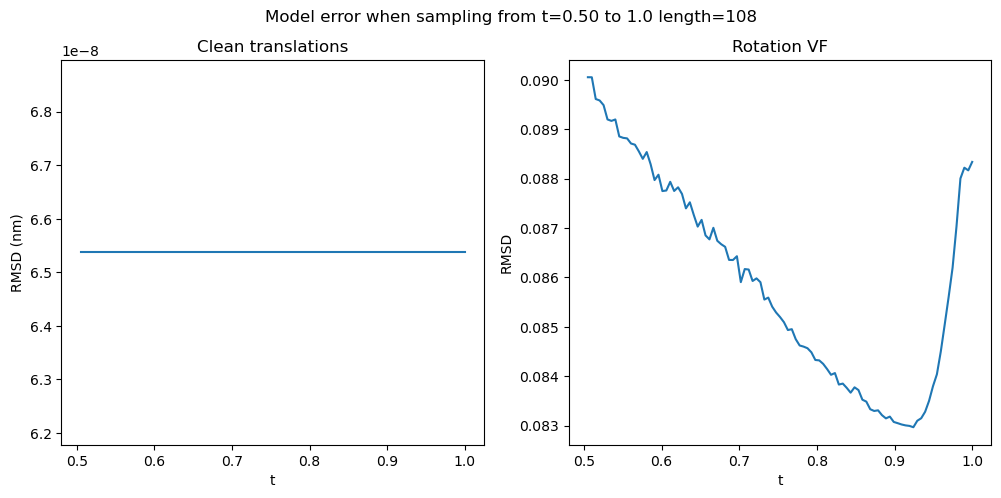

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Model error when sampling from t={min_t:.2f} to 1.0 length={num_res}')

axes[0].plot(ts[1:], aligned_ca_rmsd, label='Translations VF')
axes[0].set_xlabel('t')
axes[0].set_title('Clean translations')
axes[0].set_ylabel('RMSD (nm)')

axes[1].plot(ts[1:], rots_vf_rmsd, label='Rotation VF')
axes[1].set_xlabel('t')
axes[1].set_title('Rotation VF')
axes[1].set_ylabel('RMSD')


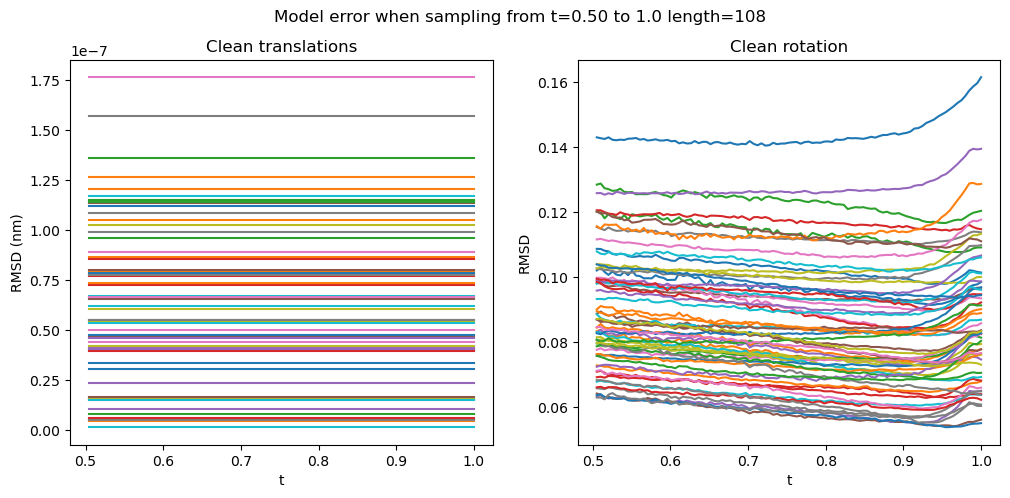

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Model error when sampling from t={min_t:.2f} to 1.0 length={num_res}')
num_batch = batch_aligned_ca_rmsd.shape[1]

for i in range(num_batch):

    axes[0].plot(ts[1:], batch_aligned_ca_rmsd[:,i])
    axes[0].set_xlabel('t')
    axes[0].set_title('Clean translations')
    axes[0].set_ylabel('RMSD (nm)')

    axes[1].plot(ts[1:], batch_rots_vf_rmsd[:,i])
    axes[1].set_xlabel('t')
    axes[1].set_title('Clean rotation')
    axes[1].set_ylabel('RMSD')


In [30]:
batch_trans_rmsd_ts = du.to_numpy(torch.linalg.norm((trans_traj - gt_trans_1[None])*0.1, dim=-1))
trans_rmsd_ts = np.mean(batch_trans_rmsd_ts, axis=(-1, -2))

batch_rots_rmsd_ts = du.to_numpy(torch.linalg.norm(rotvec_traj - gt_rotvec[None], dim=-1))
rots_rmsd_ts = np.mean(batch_rots_rmsd_ts, axis=(-1, -2))


Text(0, 0.5, 'RMSD')

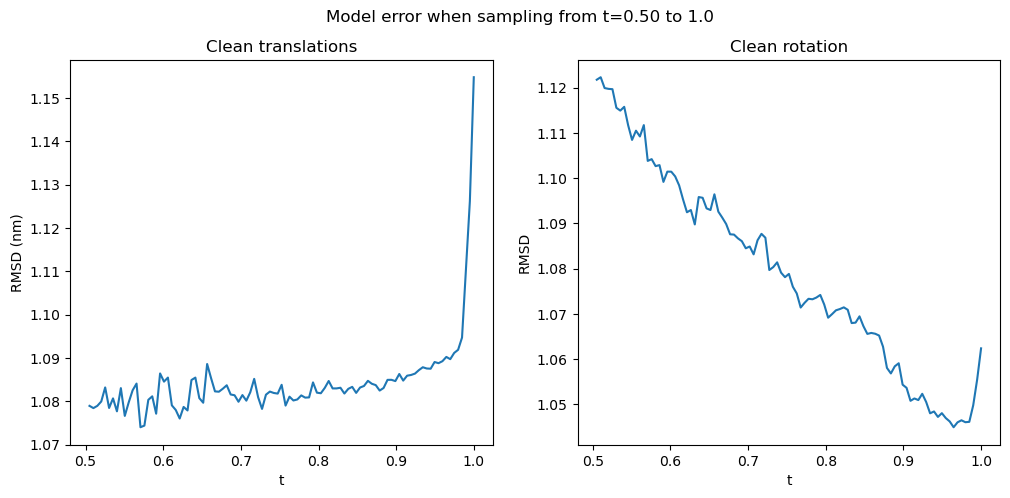

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Model error when sampling from t={min_t:.2f} to 1.0')

axes[0].plot(ts[1:], trans_rmsd_ts, label='Translations VF')
axes[0].set_xlabel('t')
axes[0].set_title('Clean translations')
axes[0].set_ylabel('RMSD (nm)')

axes[1].plot(ts[1:], rots_rmsd_ts, label='Rotation')
axes[1].set_xlabel('t')
axes[1].set_title('Clean rotation')
axes[1].set_ylabel('RMSD')


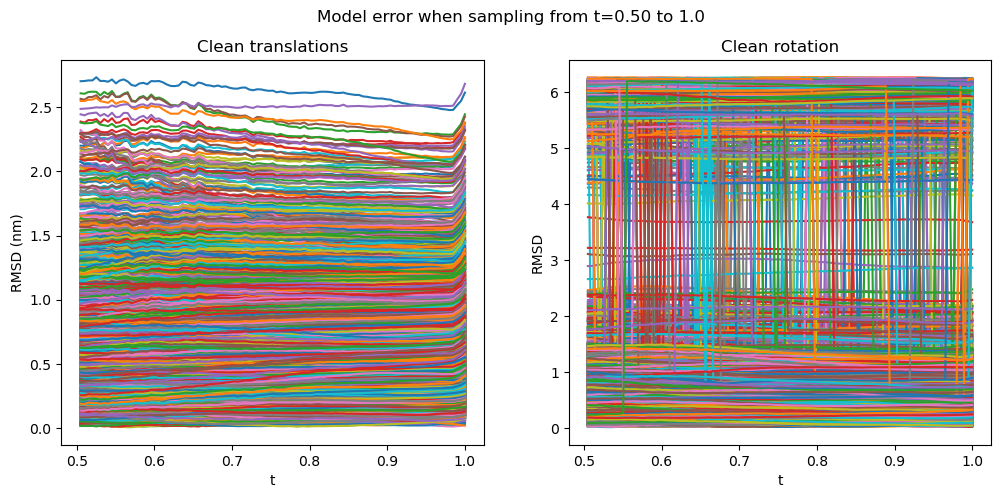

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Model error when sampling from t={min_t:.2f} to 1.0')
num_batch = batch_trans_rmsd_ts.shape[1]

for i in range(num_batch):

    axes[0].plot(ts[1:], batch_trans_rmsd_ts[:,i])
    axes[0].set_xlabel('t')
    axes[0].set_title('Clean translations')
    axes[0].set_ylabel('RMSD (nm)')

    axes[1].plot(ts[1:], batch_rots_rmsd_ts[:,i])
    axes[1].set_xlabel('t')
    axes[1].set_title('Clean rotation')
    axes[1].set_ylabel('RMSD')


## Save samples

In [23]:
# Save samples
os.makedirs(save_dir, exist_ok=True)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    traj_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'traj_{i}_len_{num_res}_t_{num_timesteps}.pdb'),
        no_indexing=True
    )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_pred_atom37[-1, i],
        os.path.join(
            save_dir,
            f'final_model_out_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_pred_atom37[:, i],
        os.path.join(
            save_dir,
            f'pred_traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_{i}_len_{num_res}_ts_{num_timesteps}.pdb',
        ),
        no_indexing=True
    )
    print(f'Done with sample {i}')

final_samples = atom37_traj[:, -1]
_ = au.write_prot_to_pdb(
    final_samples,
    os.path.join(
        save_dir,
        'all_samples.pdb'),
    no_indexing=True
)


NameError: name 'atom37_traj' is not defined